In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# Import NLTK to use its functionalities on texts
## nltk.download('punkt')
## nltk.download('wordnet')


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# We will visualize the messages with a word cloud
from wordcloud import WordCloud

# Import Conter Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


# Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

# Import Tf-idf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import the Label Encoder
from sklearn.preprocessing import LabelEncoder

# Import the train test split
from sklearn.model_selection import train_test_split

# To evaluate our model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# I will keep the resulting plots
%matplotlib inline

# Enable Jupyter Notebook's intellisense
%config IPCompleter.greedy=True

In [2]:
data = pd.read_csv('data1.csv',encoding= 'unicode_escape')

In [3]:
#Display firt five rows
display(data.head())

# Display the summary statistics
display(data.describe())

# Print the info
print(data.info())

,document_id,abstract,category
0,1,08/02/21 18:31:58 5289993007\nBanner Health\nB...,HospitalConsults
1,2,.Consultation Report\n* Final Report *\nResult...,HospitalConsults
2,3,.Consultation Report\n* Final Report *\nResult...,HospitalConsults
3,4,Fax Server\nJoyce F Proffitt\nSummary of Care ...,ProgressNotes
4,5,"PMG\nPHOENIX MEDICAL GROUP, P.C.\n08/05/2021\n...",ProgressNotes


,document_id
count,7.000000
mean,4.000000
std,2.160247
min,1.000000
25%,2.500000
50%,4.000000
75%,5.500000
max,7.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   document_id  7 non-null      int64 
 1   abstract     7 non-null      object
 2   category     7 non-null      object
dtypes: int64(1), object(2)
memory usage: 296.0+ bytes
None


In [4]:
print(data['category'].value_counts())

ProgressNotes       4
HospitalConsults    3
Name: category, dtype: int64


ProgressNotes       4
HospitalConsults    3
Name: category, dtype: int64

ProgressNotes       0.571429
HospitalConsults    0.428571
Name: category, dtype: float64


C:\Users\eklav\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


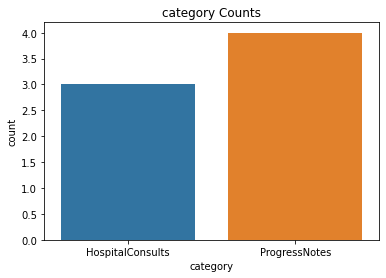

In [5]:
print(data['category'].value_counts())

print()

# Print the proportions of each category
print(data['category'].value_counts(normalize=True))

# Visualize the Categories
sns.countplot(data['category'])
plt.title("category Counts")
plt.show()

In [6]:
# Store the number of words in each messages
data['word_count'] = data['abstract'].str.split().str.len()

In [7]:
# Print the average number of words in each category
print(data.groupby('category')['word_count'].mean())

category
HospitalConsults    1322.666667
ProgressNotes       1211.250000
Name: word_count, dtype: float64


C:\Users\eklav\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\eklav\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


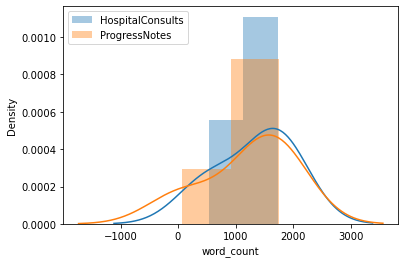

In [8]:
# Visualize the distribution of word counts in each category
sns.distplot(data[data['category']=='HospitalConsults']['word_count'], label='HospitalConsults')
sns.distplot(data[data['category']=='ProgressNotes']['word_count'], label='ProgressNotes'),
plt.legend()
plt.show()

In [9]:
# Make the letters lower case and tokenize the words
tokenized_messages = data['abstract'].str.lower().apply(word_tokenize)

# Print the tokens to see how it looks like
print(tokenized_messages)

0    [08/02/21, 18:31:58, 5289993007, banner, healt...
1    [.consultation, report, *, final, report, *, r...
2    [.consultation, report, *, final, report, *, r...
3    [fax, server, joyce, f, proffitt, summary, of,...
4    [pmg, phoenix, medical, group, ,, p.c, ., 08/0...
5    [#, 7/29/2022, 08:07, unger, peter, karl, admi...
6    [athena, 07-29-2022, 1:06, pm, et, vhs, clinic...
Name: abstract, dtype: object


In [10]:
# Define a function to returns only alphanumeric tokens
def alpha(tokens):
# This function removes all non-alphanumeric characters
    alpha = []
    for token in tokens:
        if str.isalpha(token) or token in ['n\'t','won\'t']:
            if token=='n\'t':
                alpha.append('not')
                continue
            elif token == 'won\'t':
                alpha.append('wont')
                continue
            alpha.append(token)
    return alpha

# Apply our function to tokens
tokenized_messages = tokenized_messages.apply(alpha)

print(tokenized_messages)

0    [banner, health, banner, boswell, medical, cen...
1    [report, final, report, result, type, of, serv...
2    [report, final, report, result, type, of, serv...
3    [fax, server, joyce, f, proffitt, summary, of,...
4    [pmg, phoenix, medical, group, to, whom, it, m...
5    [unger, peter, karl, admin, sex, male, dob, co...
6    [athena, pm, et, vhs, clinics, s, watson, rd, ...
Name: abstract, dtype: object


In [11]:
# Define a function to remove stop words
def remove_stop_words(tokens):
#This function removes all stop words in terms of nltk stopwords
    no_stop = []
    for token in tokens:
        if token not in stopwords.words('english'):
            no_stop.append(token)
    return no_stop


In [12]:
# Apply our function to tokens
tokenized_abstract = tokenized_messages.apply(remove_stop_words)

print(tokenized_abstract)

0    [banner, health, banner, boswell, medical, cen...
1    [report, final, report, result, type, service,...
2    [report, final, report, result, type, service,...
3    [fax, server, joyce, f, proffitt, summary, car...
4    [pmg, phoenix, medical, group, may, concern, a...
5    [unger, peter, karl, admin, sex, male, dob, co...
6    [athena, pm, et, vhs, clinics, watson, rd, buc...
Name: abstract, dtype: object


In [13]:
# Define a function to lemmatization
def lemmatize(tokens):
    ## This function lemmatize the messages
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    # Create the lemmatized list
    lemmatized = []
    for token in tokens:
            # Lemmatize and append
            lemmatized.append(lemmatizer.lemmatize(token))
    return " ".join(lemmatized)

# Apply our function to tokens
tokenized_messages = tokenized_abstract.apply(lemmatize)

print(tokenized_abstract)

0    [banner, health, banner, boswell, medical, cen...
1    [report, final, report, result, type, service,...
2    [report, final, report, result, type, service,...
3    [fax, server, joyce, f, proffitt, summary, car...
4    [pmg, phoenix, medical, group, may, concern, a...
5    [unger, peter, karl, admin, sex, male, dob, co...
6    [athena, pm, et, vhs, clinics, watson, rd, buc...
Name: abstract, dtype: object


In [14]:
# Replace the columns with tokenized messages
data['abstract'] = tokenized_messages

# Display the first five rows
display(data.head())

,document_id,abstract,category,word_count
0,1,banner health banner boswell medical center w ...,HospitalConsults,533
1,2,report final report result type service result...,HospitalConsults,1736
2,3,report final report result type service result...,HospitalConsults,1699
3,4,fax server joyce f proffitt summary care docum...,ProgressNotes,1293
4,5,pmg phoenix medical group may concern abraham ...,ProgressNotes,68


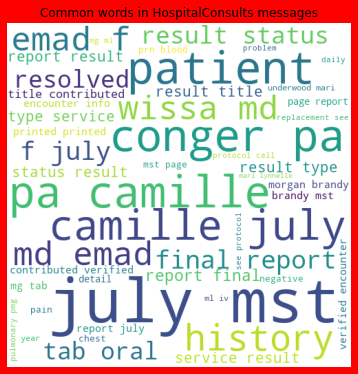

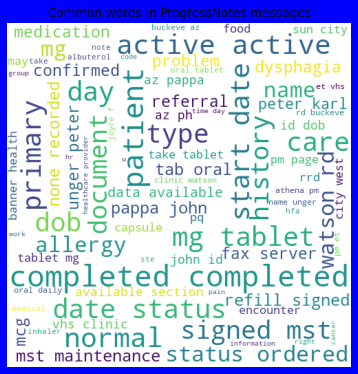

In [15]:
# Get the hospitalconsult messages
HospitalConsults = data[data['category']=='HospitalConsults']['abstract'].str.cat(sep=', ')

# Get the progressnote messages
ProgressNotes = data[data['category']=='ProgressNotes']['abstract'].str.cat(sep=', ')

# Initialize the word cloud
wc = WordCloud(width = 500, height = 500, min_font_size = 10, background_color ='white')

# Generate the world clouds for each type of message
hospitalconsults_wc = wc.generate(HospitalConsults)

# plot the world cloud for hospitalconsults                     
plt.figure(figsize = (5, 5), facecolor = 'Red') 
plt.imshow(hospitalconsults_wc) 
plt.axis("off") 
plt.title("Common words in HospitalConsults messages")
plt.tight_layout(pad = 0) 
plt.show() 
progressnotes_wc = wc.generate(ProgressNotes)

# plot the world cloud for hospitalprogressnotes                       
plt.figure(figsize = (5, 5), facecolor = 'Blue') 
plt.imshow(progressnotes_wc) 
plt.axis("off")
plt.title("Common words in ProgressNotes messages")
plt.tight_layout(pad = 0) 
plt.show() 

In [16]:
# Select the features and the target
# X = data['abstract']
# y = data['category']
X_train = data['abstract']
y_train = data['category']

In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)

In [18]:
X_train.head()

0    banner health banner boswell medical center w ...
1    report final report result type service result...
2    report final report result type service result...
3    fax server joyce f proffitt summary care docum...
4    pmg phoenix medical group may concern abraham ...
Name: abstract, dtype: object

In [19]:
count_vect = CountVectorizer()
count_vect.fit(X_train)
count_vect_transform = count_vect.transform(X_train)

In [20]:
count_vect_transform

<7x1497 sparse matrix of type '<class 'numpy.int64'>'
	with 2453 stored elements in Compressed Sparse Row format>

In [21]:
count_vect_transform.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 3],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0]], dtype=int64)

In [22]:
pd.DataFrame(count_vect_transform.toarray(), columns = count_vect.get_feature_names()).head()

C:\Users\eklav\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abbreviated,abdomen,abdominal,abdullah,able,abnormal,abnormality,abraham,abrazo,abuse,...,year,yes,yesterday,yet,yonan,yousif,zofran,zostavax,zoster,zosyn
0,0,0,0,0,0,2,0,0,0,0,...,9,0,1,0,0,1,0,0,0,0
1,0,0,1,0,0,1,0,0,0,1,...,3,0,2,0,0,0,1,0,0,3
2,0,0,0,4,0,0,0,0,0,0,...,1,0,1,0,5,0,1,0,0,0
3,0,1,4,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
4,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
tfidf_vect = TfidfTransformer()
X_train_tfidf = tfidf_vect.fit(count_vect_transform)
X_train_tfidf_transform = X_train_tfidf.transform(count_vect_transform)

In [24]:
pd.DataFrame(X_train_tfidf_transform.toarray(), columns = count_vect.get_feature_names()).head(25)

C:\Users\eklav\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abbreviated,abdomen,abdominal,abdullah,able,abnormal,abnormality,abraham,abrazo,abuse,...,year,yes,yesterday,yet,yonan,yousif,zofran,zostavax,zoster,zosyn
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.069309,0.000000,0.000000,0.000000,0.000000,...,0.266594,0.000000,0.029622,0.000000,0.000000,0.041748,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.011775,0.000000,0.000000,0.013776,0.000000,0.000000,0.000000,0.013776,...,0.035325,0.000000,0.023550,0.000000,0.000000,0.000000,0.013776,0.000000,0.000000,0.049787
2,0.000000,0.000000,0.000000,0.052439,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009302,0.000000,0.009302,0.000000,0.065549,0.000000,0.010882,0.000000,0.000000,0.000000
3,0.000000,0.024167,0.068587,0.000000,0.020060,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.024167,0.000000,0.000000,0.000000,0.024167,0.024167,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.343698,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.015982,0.000000,0.011340,0.000000,0.013266,0.000000,0.031964,0.000000,0.031964,0.013266,...,0.000000,0.015982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
clsfy = MultinomialNB().fit(X_train_tfidf_transform, y_train)

In [26]:
print(clsfy.predict(count_vect.transform(["History of Present IllnessThe patient presents with a new problem. Patient is a 63 year old with a past medical history of stroke with residual right weakness  depression  htnwho presents with dizziness  right face numb. History is per patient  chart. Notes from other providers since admission reviewed  labs reviewed imaging results reviewed  medication list reviewed. Patient has residual right face droop from old stroke. Yesterday he felt dizzy and numb on right face.This is better now. No inciting  alleviating  exacerbating factors. Patient denies smoking  drinking alcohol  or using illicit drugs. Family history reviewedand noncontributory to this presentation..Cardiovascular: No chest pain.Gastrointestinal: No nausea  No vomiting  No diarrhea.Genitourinary: No dysuria.Integumentary: No rash.Musculoskeletal: No muscle pain.Neurologic: Numbness  No abnormal balance  No confusion  No tingling  No headache.Psychiatric: no mood change  No hallucinations."])))

['HospitalConsults']


In [27]:
print(clsfy.predict(count_vect.transform([".Physician Progress Notes * Final Report * Result type: Date/Time of Service: Result status: Result title: Contributed By: Verified by:Encounter info: .Physician Progress Notes June 13, 2021 11:48 PDT Auth (Verified)all results reviewed and discussed with ptinternal medicine progress note DABAS MD, RIDHIMA on June 13, 2021 11:51 MST DABAS MD, RIDHIMA on June 13, 2021 11:51 MST84516491, BTMC, Observation, 06/12/2021 - 06/14/2021 Plan assessment and plan- 1. Chest pain,-troponin negative EKG negative appears typical as patient feels the pain is similar to the last episode when he had stents placed 2 years ago. Patient is continuing to be symptomatic trial of oral nitroglycerin. We will get a stat EKG cardiology consulted. Continue medical management. We will follow 2. CAD - Coronary artery disease -continue medical management already on aspirin statin as needed nitroglycerin andmorphine 3. Chronic back pain -Resume home narcotic medications, patient on scheduled oxycodone at home which is continuedat home dose avoid more narcotics if not needed diet-cardio activity-as tolerated code status-full PT/CM-no needs TUTRONE, HERBERT NEIL - 197948 4. Hypertension -blood pressure slightly elevated could be secondary to pain continue to monitor add medications astolerated5. COPD - Chronic obstructive pulmonary disease Inhalers as needed does not appear to be exacerbateddvt/gi prophyalxis Lovenox tolerating oralall questions answered and d.w pt/RNDISPO - dependig on clinical course awaiting cardiologyPrinted by:Printed on:Completed Action List:* Perform by DABAS MD, RIDHIMA on June 13, 2021 11:51 MST*Sign by DABAS MD, RIDHIMA on June 13, 2021 11:51 MST* VERIFY by DABAS MD, RIDHIMA on June 13, 2021 11:51 MSTValladares, Luz09/07/2021 11:36 PDTPage 5 of 6.Physician Progress Notes* Final Report *Result type:Date/Time of Service:Result status:Result title:Contributed By:Verified by:Encounter info:Printed by:Printed on:.Physician Progress NotesJune 13, 2021 11:48 PDTAuth (Verified)TUTRONE, HERBERT NEIL - 197948internal medicine progress noteDABAS MD, RIDHIMA on June 13, 2021 11:51 MSTDABAS MD, RIDHIMA on June 13, 2021 11:51 MST84516491, BTMC, Observation, 06/12/2021 - 06/14/2021Valladares, Luz09/07/2021 11:36 PDTPage 6 of 6"])))

['HospitalConsults']


In [28]:
print(clsfy.predict(count_vect.transform(["Pyhysician Progress Notes Result type: .Physician Progress Notes June 13 This is an abnormal routine- awake and drowsy EEG due to diffuse mildbackground slowing consistent with encephalopathy, possible "])))

['ProgressNotes']


In [29]:
import pickle

pickle.dump(count_vect,open('count_vect.pkl', 'wb'))
pickle.dump(clsfy, open('lf.pkl', 'wb'))

In [30]:
# pip install -U scikit-learn

In [31]:
# pip install scikit-learn==0.22.2.post1